In [457]:
%config IPCompleter.greedy=True
from IPython.display import IFrame
# from MyLearner import MyLearner

# from MyScorer import MyScorer
# from MyPlotter import MyPlotter

import pandas as pd
import numpy as np
import string
import itertools

import math
import scipy.stats as sts
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
import sklearn.feature_selection as feature_selection
import sklearn.preprocessing as prepc
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.multiclass import OneVsOneClassifier as ovo
from sklearn.multiclass import OutputCodeClassifier as occ
import sklearn
import sklearn.metrics as metrics
from rfpimp import dropcol_importances
from rfpimp import importances
import imblearn.over_sampling as imbOVS
import imblearn.under_sampling as imbUDS
import imblearn.combine as imbCMB

from dabl.plot import class_hists

In [458]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

### Training Set

In [459]:
data_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test Set

In [460]:
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking missing values in training set

In [461]:
nulls = data_train.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
N = len(data_train.index)
nulls.insert(1, 'percent', ['{0:.2%}'.format(nulls.loc['Age'][0] / N), 
                            '{0:.2%}'.format(nulls.loc['Cabin'][0] / N),
                            '{0:.2%}'.format(nulls.loc['Embarked'][0] / N)])
nulls

,count,percent
Age,177,19.87%
Cabin,687,77.10%
Embarked,2,0.22%


Seems to be a lot of missing values in 'Age' and 'Cabin'.

As I concluded from preliminary analysis, the Age is one of the critical and must be treated first.

The Cabin and Embarked are probably not important in Survival prediction.

I will come to nulls later but for now lets look on distributions.

### Checking missing values in test set

In [462]:
nulls = data_test.isnull().sum()
nulls = nulls.loc[nulls > 0]
nulls = nulls.to_frame(name='count')
nulls

,count
Age,86
Fare,1
Cabin,327


#### Calculate survival rate

In [463]:
#how many died
N_surv0 = len(data_train.loc[data_train['Survived']==0])
#how many survived
N_surv1 = len(data_train.loc[data_train['Survived']==1])

print('Deads: {0} ({1:.2%})'.format(N_surv0, N_surv0 / N))
print('Survivals: {0} ({1:.2%})'.format(N_surv1, N_surv1 / N))

Deads: 549 (61.62%)
Survivals: 342 (38.38%)


Well, only 1/3 survived. That was expectable though.

In [464]:
data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

#encode categorical variables
data['Sex'] = data['Sex'].apply(lambda i: 1 if i=='male' else 0)
data['Embarked'] = data['Embarked'].apply(lambda i: 0 if i=='C' else (1 if i=='Q' else 2))
data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
# data = pd.concat([data.drop(columns=['Sex', 'Embarked']), df1, df2], axis=1)

#add family size
data['famsize'] = data['SibSp'] + data['Parch']

#numerical data
data_num = data[['Age', 'Fare',]]

#categorical data
data_cat = data[['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'famsize']]

In [465]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,famsize
0,0,2,1,22.0,1,0,7.2500,2,1
1,1,0,0,38.0,1,0,71.2833,0,1
2,1,2,0,26.0,0,0,7.9250,2,0
3,1,0,0,35.0,1,0,53.1000,2,1
4,0,2,1,35.0,0,0,8.0500,2,0


### Plotting Variables

In [466]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

In [467]:
def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

In [468]:
def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

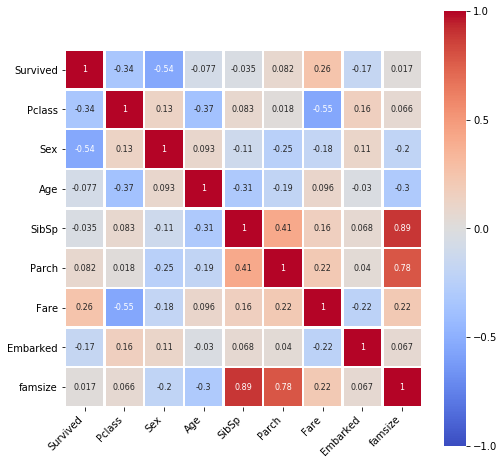

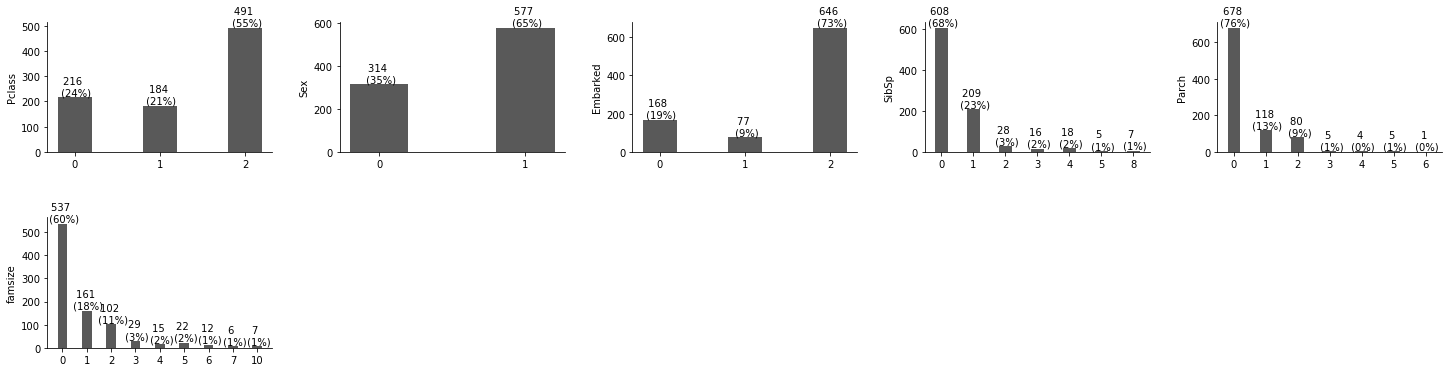

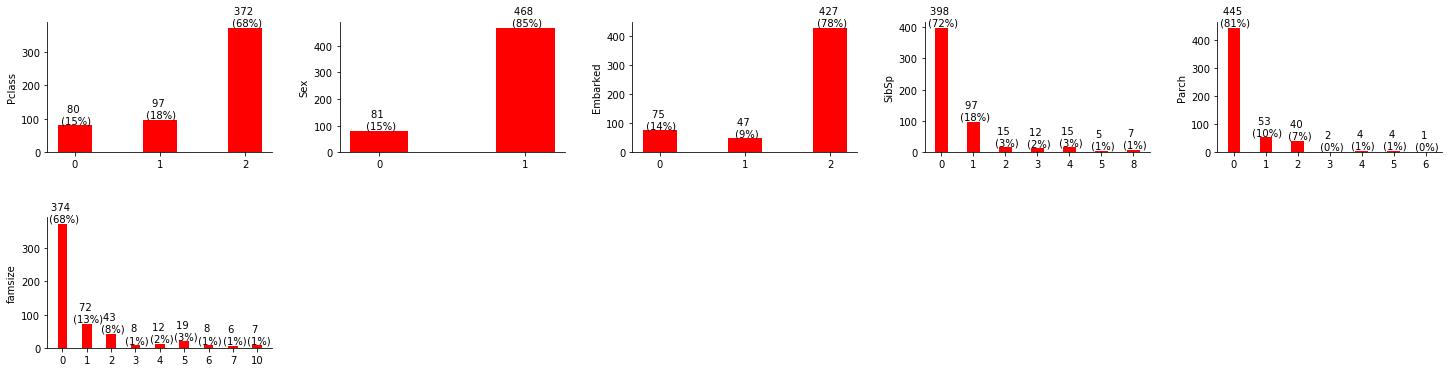

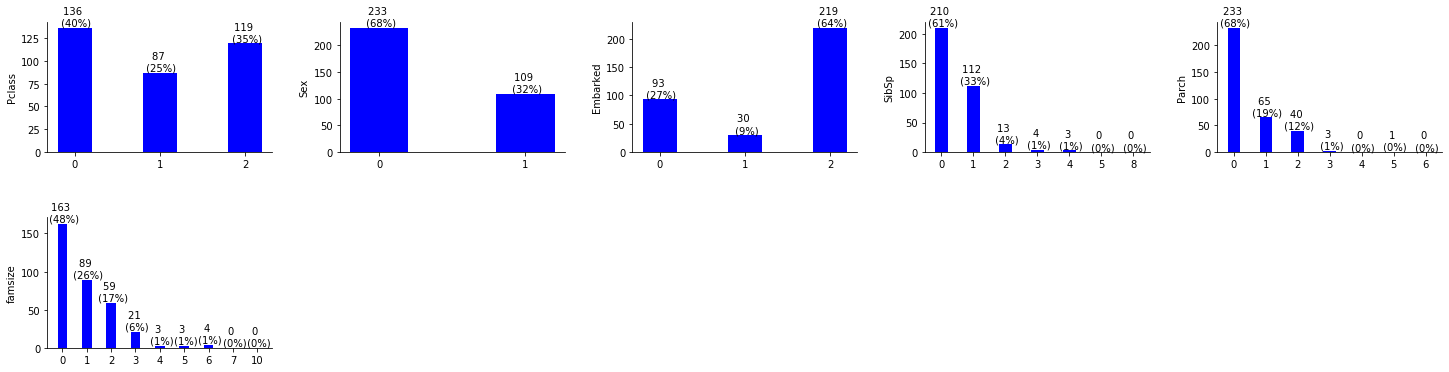

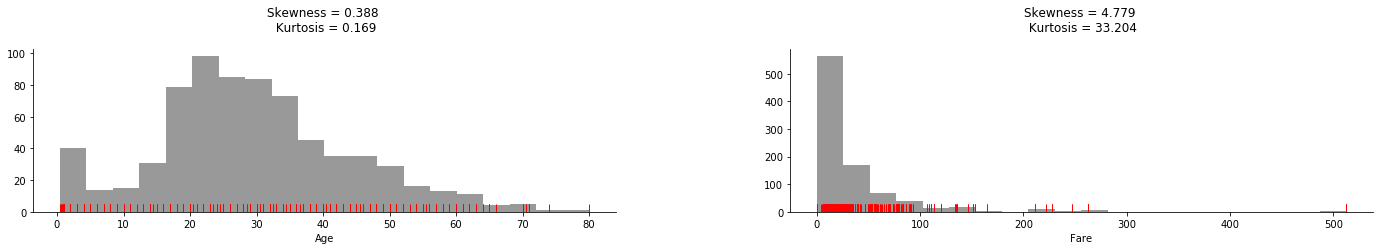

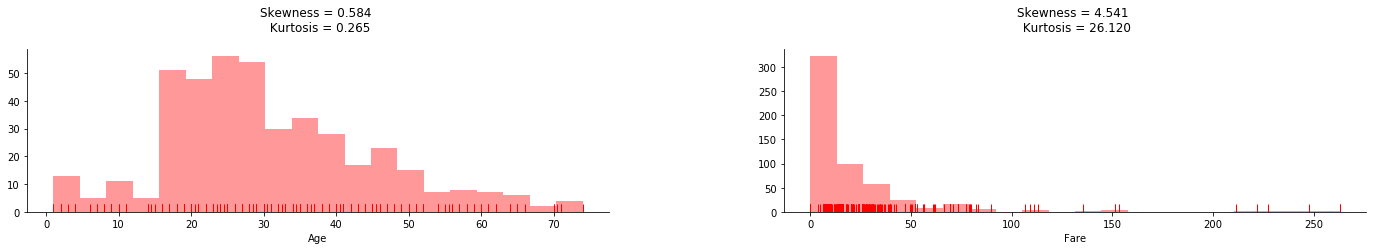

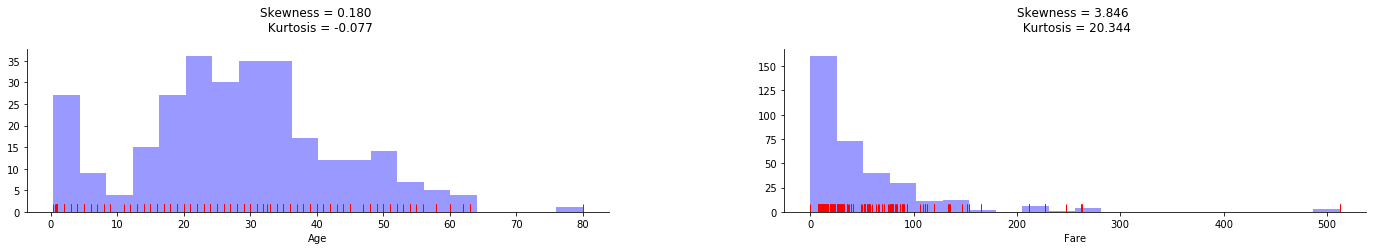

In [469]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')


grd = list(data_cat.columns)
grd_n = len(grd)
grd_cols_n = 5
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 5

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n = len(data.loc[data[col]==i, col].index)
        fr = n / len(data.index)
        freq.append([n])
        frc.append([fr])

    df_freq = pd.DataFrame(freq, columns=['all'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['all'], index=data_cat[col].unique()).T
    labs = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['all'], df_frc.loc['all'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs],
                           plots_labels=None,
                           plots_colors=['0.35'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (non-survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n0 = len(data.loc[(data['Survived']==0) & (data[col]==i), col].index)
        fr0 = n0 / N_surv0
        freq.append([n0])
        frc.append([fr0])

    df_freq = pd.DataFrame(freq, columns=['non_survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['non_survivals'], index=data_cat[col].unique()).T
    labs0 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['non_survivals'], df_frc.loc['non_survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs0],
                           plots_labels=None,
                           plots_colors=['r'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Categorical Variables (survivals)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_cat.columns):
    freq = []
    frc = []
    for i in np.sort(data_cat[col].unique()):
        n1 = len(data.loc[(data['Survived']==1) & (data[col]==i), col].index)
        fr1 = n1 / N_surv1
        freq.append([n1])
        frc.append([fr1])

    df_freq = pd.DataFrame(freq, columns=['survivals'], index=np.sort(data_cat[col].unique())).T
    df_frc = pd.DataFrame(frc, columns=['survivals'], index=data_cat[col].unique()).T
    labs1 = ['{0:d} \n ({1:.0%})'.format(i,j) for i, j in zip(df_freq.loc['survivals'], df_frc.loc['survivals'])]
    plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                           data=df_freq,
                           bar_labels=[labs1],
                           plots_labels=None,
                           plots_colors=['b'],
                           title=None,
                           length_label=col,
                           orient='v',
                           spines={'top': False, 'right': False})
    

    
grd = list(data_num.columns)
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 3
plt_w = 12

fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (all)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data[col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "0"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (NON-SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==0, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "r"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))
    
fig_ttl = plt.figure()
fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
ax0 = fig_ttl.add_subplot()
ax0.text(0.5, 0.5, 'Numerical Variables (SURVIVALS)', fontsize=14, horizontalalignment='center', verticalalignment='center')
ax0.axis('off')

fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

for idx, col in enumerate(data_num.columns):
    fig.add_subplot(gs[idx])
    df = data.loc[data['Survived']==1, col].dropna()
    ax = sns.distplot(df,
                 bins=20, kde=False, norm_hist=False, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Skewness = {0} \n Kurtosis = {1}'.format(skewness, kurtosis))


#### Define age intervals using clastering

In [470]:
#Transform 'Age'
df_age = data_train['Age'].dropna()

age_trans = df_age.apply(lambda i: np.log(i+1)).to_frame()
age_trans.columns = ['Age_trans']
df_age = pd.concat([df_age.to_frame(), age_trans], axis=1)

In [471]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=2, covariance_type='spherical', tol=0.001, reg_covar=1e-06, max_iter=1000, n_init=1, 
                                 init_params='kmeans', weight_concentration_prior_type='dirichlet_distribution', 
                                 weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, 
                                 degrees_of_freedom_prior=None, covariance_prior=None, random_state=30)
                                 
#Predict class labels
age_cls = pd.DataFrame(age_clast_model.fit_predict(np.array(df_age['Age_trans']).reshape(-1,1)), columns=['Age_cls'])
age_cls = age_cls.astype(int)

In [472]:
df_age = pd.concat([df_age.reset_index(), age_cls], axis=1).drop(columns='index')

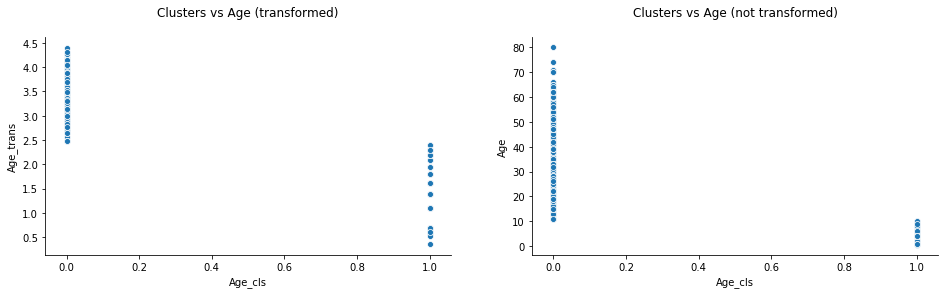

In [473]:
fig = plt.figure()
fig.set_size_inches(16,4)

fig.add_subplot(1,2,1)
ax = sns.scatterplot(x='Age_cls', y='Age_trans', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (transformed)')

fig.add_subplot(1,2,2)
ax = sns.scatterplot(x='Age_cls', y='Age', data=df_age)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.07])
a=ax.set_title('Clusters vs Age (not transformed)')

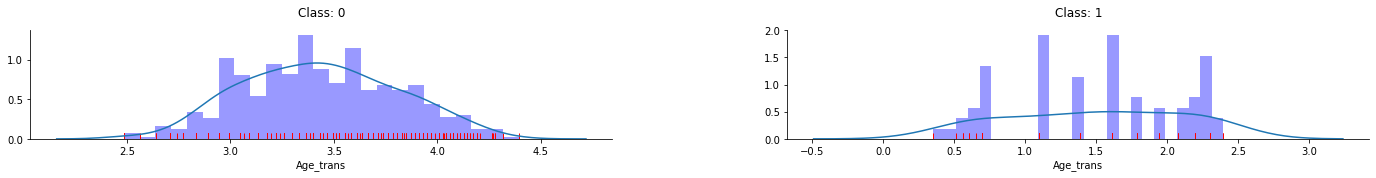

In [474]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age_trans']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

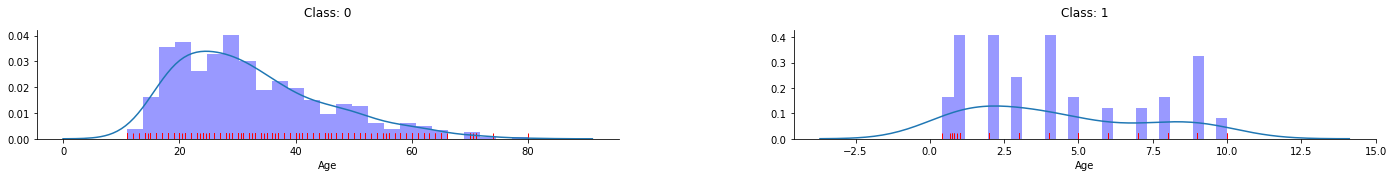

In [475]:
grd = sorted(df_age['Age_cls'].unique())
grd_n = len(grd)
grd_cols_n = 2
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

plt_h = 2
plt_w = 12


fig = plt.figure()
fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.8)

for idx, c in enumerate(grd):
    fig.add_subplot(gs[idx])
    df = df_age.loc[df_age['Age_cls']==c, 'Age']
    ax = sns.distplot(df,
                 bins=25, kde=True, norm_hist=True, rug=True, 
                 rug_kws={'color':'r'},
                 hist_kws={'histtype':'bar', 'linewidth': 3, 'color': "b"})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    skewness = '{0:.3f}'.format(sts.skew(df.values))
    kurtosis = '{0:.3f}'.format(sts.kurtosis(df.values))
    ttl = ax.title
    ttl.set_position([.5, 1.07])
    ax.set_title('Class: {0}'.format(c))

In [476]:
def age_transformer(data, model):
    age_trans = np.array(data['Age'].apply(lambda i: np.log(i+1))).reshape(-1,1)
    age_cls = pd.DataFrame(model.fit_predict(age_trans), columns=['Age_cls'])
    age_cls = age_cls.astype(int)
    data = pd.concat([data.drop(columns=['Age']).reset_index(), pd.DataFrame(age_trans, columns=['Age'])], axis=1).drop(columns='index')
    return pd.concat([data.reset_index(), age_cls], axis=1).drop(columns='index')

#### Replace 'Name' with encoded titles

In [477]:
#Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [478]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(), data_encoded], axis=1).drop(columns=['index'])

In [479]:
data_tot = name_encoder(data_tot)
data_tot.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Thayer,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Peel,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,,Mr


In [480]:
#Find unique titles and their counts
ttl = data_tot['ttl'].unique()
ttl = pd.DataFrame([[i, len(data_tot.loc[data_tot['ttl']==i])] for i in ttl], columns=['ttl', 'ttl_n'])
ttl.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ttl,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer,Dona
ttl_n,757,197,260,61,1,8,8,1,2,2,1,1,2,4,1,1,1,1


In [481]:
#Explore samples with 'Dr' title
data_tot.loc[data_tot['ttl']=='Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
245,246,0.0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,,Dr
317,318,0.0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,,Dr
398,399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,,Dr
632,633,1.0,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,,Dr
660,661,1.0,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,,Dr
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,,Dr
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Farnham,Dr
1184,1185,NaN,1,"Dodge, Dr. Washington",male,53.0,1,1,33638,81.8583,A34,S,Dodge,,Dr


_**There is only one woman with title 'Dr'._

The function below will replace each person's name with encoded title. Instead of using all unique titles, I will teke only these: 'Mr', 'Mrs', 'Miss' and 'Master'.

In [482]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    df = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    data = pd.concat([data.drop(columns=['ttl']), df], axis=1)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    df = data['ttl'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['ttl']), df], axis=1)

In [483]:
data_tot = title_encoder(data_tot)

#### Explore missing values for 'Embarked'

In [484]:
data_tot.loc[data_tot['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,,3
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Evelyn,2


Display samples with similar ticket number

In [485]:
df = data_tot.query('Ticket.str.contains("1135")')
df.sort_values(by='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lname0,lname1,ttl
782,783,0.0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,Long,,1
377,378,0.0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Widener,,1
965,966,NaN,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.5000,C130,C,Geiger,,3
966,967,NaN,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.5000,C132,C,Keeping,,1
1109,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,Widener,Elkins,2
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,,1
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,Chibnall,Bowerman,2
356,357,1.0,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,Bowerman,,3
54,55,0.0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,Ostby,,1
917,918,NaN,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C,Ostby,,3


All people with similar ticket numbers are embarked in 'C' or 'S'. So i will simply assign the most frequent class for both missed values.

In [486]:
nc = len(df.loc[df['Embarked']=='C'])
ns = len(df.loc[df['Embarked']=='S'])
n = len(df.index)

print('C: %d' % nc)
print('S: %d' % ns)
print('All: %d' % n)

C: 7
S: 5
All: 14


The function below will be used to encode 'Embarked' variable

In [487]:
#Encoding 'Embarked'
def embarked_encoder(data):
#     data = data.copy()
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data
            
#Encoding 'Pclass'
def pclass_encoder(data):
#     data = data.copy()
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

In [488]:
data_tot = embarked_encoder(data_tot)
data_tot = pclass_encoder(data_tot)

### Grouping by ticket ID

While exploring the dataset, I found that many passengers have identical ticket numbers as well as identical fare value.

In this section I will do two things:
1. Group all passengers by ticked ID and add a column of the gropus IDs.
2. For all people with matching tickets, I will recalculate ticket fare for every i-th person in a group g as: fare(i, g) = fare(g) / n, where n is a number of people in group g.

~~3. Transform fare into categorical variable.~~

In [489]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [490]:
# This function will clean ticket ID from all punctuation and spaces
def ticket_encoder(data):
    df = data['Ticket'].apply(lambda i: clean_text(i)).to_frame()
    data = pd.concat([data.drop(columns=['Ticket']).reset_index(), df], axis=1)
    return data.drop(columns=['index'])

In [491]:
data_tot = ticket_encoder(data_tot)

Numbers of unique and non-unique tickets:

In [492]:
print('Unique tickets: %d' % len(data_tot['Ticket'].unique()))
print('Non-unique tickets: %d' % (len(data_tot.index) - len(data_tot['Ticket'].unique())))

Unique tickets: 929
Non-unique tickets: 380


I want to define the following groups:
1. No family (SibSp==0 & Parch==0), unique tickets
2. No family (SibSp==0 & Parch==0), non-unique tickets
3. Has family, no children (SibSp >0 & Parch==0), unique tickets
4. Has family, no children (SibSp >0 & Parch==0), non-unique tickets
5. Has family, has children (Parch >0), unique tickets
6. Has family, has children (Parch >0), non-unique tickets

In [493]:
families0 = data_tot.loc[(data_tot['SibSp']>0) & (data_tot['Parch']==0)]
families1 = data_tot.loc[data_tot['Parch']>0]
singles = data_tot.loc[(data_tot['SibSp']==0) & (data_tot['Parch']==0)]

In [494]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [495]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

print('Singles-----------------------')
print('Matching tickets groups: %d' % len(sig1.index))
print('Unique tickets groups: %d' % len(sig0.index))
print('------------------------------')

print('Families----------------------')
print('Matching tickets groups: %d' % len(fam1.index))
print('Unique tickets groups: %d' % len(fam0.index))
print('------------------------------')

print('Families W/children-----------')
print('Matching tickets groups: %d' % len(famch1.index))
print('Unique tickets groups: %d' % len(famch0.index))
print('------------------------------')

Singles-----------------------
Matching tickets groups: 108
Unique tickets groups: 682
------------------------------
Families----------------------
Matching tickets groups: 174
Unique tickets groups: 38
------------------------------
Families W/children-----------
Matching tickets groups: 288
Unique tickets groups: 19
------------------------------


In [496]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [497]:
# Encode family groups
def family_groups_encoder(data, fam_grps):
#     data = data.copy()
    data['fgrp'] = 0
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            data.loc[data['PassengerId']==pid, 'fgrp'] = idx
    return data

In [498]:
# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, encode_grps):
    for grp in encode_grps:
        fare = grp['Fare'].values[0] / len(grp.index)
        grp['Fare'] = fare
        for pid in grp['PassengerId']:
            if pid in data['PassengerId']:
                data.loc[data['PassengerId']==pid, 'Fare'] = fare
    if len(data.loc[data['Fare'].isnull()])>0:
        for pid in data.loc[data['Fare'].isnull(), 'PassengerId']:
            c = data.loc[data['PassengerId']==pid, 'Pclass'].values[0]
            data.loc[data['PassengerId']==pid, 'Fare'] = np.mean(data.loc[data['Pclass']==c, 'Fare'])
    return data

In [499]:
def family_encoder(data, match_ticket_grps):
#     data = data.copy()
    data['mtickets'] = 0
    data['famsize'] = data['SibSp'] + data['Parch']
    data['SibSp'] = data['SibSp'].apply(lambda i: 1 if i > 0 else 0)
    data['Parch'] = data['Parch'].apply(lambda i: 1 if i > 0 else 0)
    for pid in data['PassengerId']:
        for grp in match_ticket_grps:
            if pid in grp['PassengerId']:
                data.loc[data['PassengerId']==pid, 'mtickets'] = 1
    return data

In [500]:
# Encode fare
def fare_transformer(data):
#     data = data.copy()
    data['Fare'] = data['Fare'].apply(lambda i: np.log(i+1))
#     kbd = prepc.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
#     c = pd.DataFrame(kbd.fit_transform(np.array(data['Fare']).reshape(-1,1)), columns=['Fare'])
#     c = c.astype(int)
#     data = pd.concat([data.drop(columns=['Fare']).reset_index(), c], axis=1).drop(columns='index')
    return data

In [501]:
data_tot = family_groups_encoder(data_tot, fam_grps)
data_tot = family_encoder(data_tot, [sig1, fam1, famch1])
data_tot = fare_encoder(data_tot, [sig1, fam1, famch1])
# data_tot = fare_transformer(data_tot)

Functions for sex encoding and to add a family size variable:

In [502]:
# Encode 'Sex'
def sex_encoder(data):
#     data = data.copy()
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

In [503]:
# Add 'Familie size'
def fam_size(data):
#     data = data.copy()
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

In [504]:
def combine_features(data, feature1, feature2, name):
    lst1 = list(data[feature1].unique())
    lst2 = list(data[feature2].unique())
    d1 = len(lst1)
    d2 = len(lst2)
    mask = np.array(range(d1 * d2)).reshape(d1,d2)
    data = data.copy()
    df = []
    for i in data.index:
        df.append([mask[lst1.index(data[feature1][i])][lst2.index(data[feature2][i])]])
    df = pd.DataFrame(df, columns=[name])
    return pd.concat([data.reset_index(), df], axis=1).drop(columns='index')

In [505]:
data_tot = sex_encoder(data_tot)
# data_tot = fam_size(data_tot)
data_tot = combine_features(data_tot, 'Pclass', 'Embarked', 'PclEmb')

In [506]:
data_tot.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked', 'lname0', 'lname1', 'ttl', 'Ticket',
       'fgrp', 'mtickets', 'famsize', 'Sex', 'PclEmb'],
      dtype='object')

### Predict missing missing values for age

In [507]:
data = data_tot[data_tot['Age'].notna()].copy()
data = data[['Age', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]

In [508]:
data = age_transformer(data, age_clast_model)

In [509]:
# X = add_counts(X, ['Fare'])
data['Fare'] = data['Fare'].apply(lambda i: np.log(i+1) * len(data.loc[data['Fare']==i].index))

Plot correlation matrix:

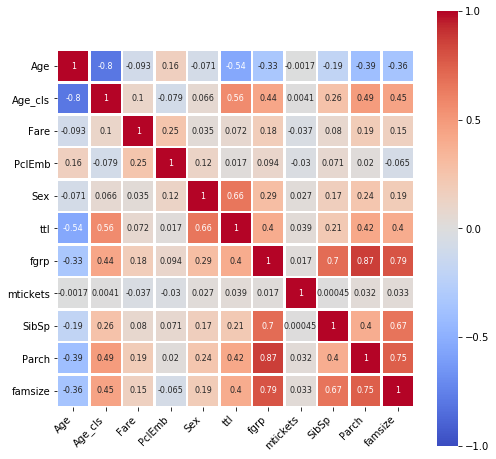

In [510]:
data = data[['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets', 'SibSp', 'Parch', 'famsize']]
fig = plt.figure()
fig.set_size_inches(8, 8)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [511]:
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

In [512]:
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

In [513]:
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [514]:
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

In [515]:
def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

In [516]:
def dropcol_imp_roc_auc_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.roc_auc_score(y_valid, y_pred, sample_weight=sample_weights)

In [517]:
def dropcol_imp_accuracy_metric(model, X_valid, y_valid, sample_weights):
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred, sample_weight=sample_weights)

In [518]:
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [519]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [520]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [521]:
def add_counts(data, columns):
    for col in columns:
        data[col] = data[col].apply(lambda i: i * len(data.loc[data[col]==i].index))
    return data

In [522]:
data.columns

Index(['Age', 'Age_cls', 'Fare', 'PclEmb', 'Sex', 'ttl', 'fgrp', 'mtickets',
       'SibSp', 'Parch', 'famsize'],
      dtype='object')

In [523]:
# train test split
X = data.drop(columns=['Age', 'Age_cls', 'Sex', 'mtickets', 'SibSp', 'Parch', 'famsize'])
y = data['Age_cls']

In [524]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
# refit = 'balanced_accuracy'

In [525]:
params = {'learning_rate': 0.13179487, 
          'n_estimators': 85,
          'min_weight_fraction_leaf': 0.029487179487, 
          'min_impurity_decrease': 0.0022857,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
age_cls_model.fit(X,y)
cv_rep(age_cls_model, X, y, cv, scoring)

# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 40), 'n_estimators': np.arange(5, 100, 20)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.01, 15)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'max_depth': np.arange(2,10)}
# age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.972258,0.993741,0.903244
std_train,0.016774,0.001319,0.018890
mean_test,0.962754,0.991308,0.890875
std_test,0.030999,0.002581,0.021398


In [526]:
# train test split
X = data.drop(columns=['Age', 'Sex', 'mtickets', 'SibSp', 'Parch', 'famsize'])
y = data['Age']

In [527]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
#cross validation metrics
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

In [528]:
params = {'learning_rate': 0.0593846, 
          'n_estimators': 85,
          'min_weight_fraction_leaf': 0.044137931, 
          'min_impurity_decrease': 0.00478947368,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.0001545454}

age_reg_mogel = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
age_reg_mogel.fit(X,y)
cv_rep(age_reg_mogel, X, y, cv, scoring)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.01, 0.1, 30), 'min_impurity_decrease': np.linspace(0.0001, 0.01, 20)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.1, 30)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.1, 30)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.001, 100)}
# age_reg_mogel, scores = train_best_model(age_reg_mogel, param_ranges, X, y, scoring, cv, refit=refit)

,explained_variance,r2
mean_train,0.728076,0.728076
std_train,0.010813,0.010813
mean_test,0.702238,0.700568
std_test,0.058610,0.059199


### Preprocess train set for classification

**Pipeline:**
1. Encode name
2. Encode title
3. Encode embarked
4. Encode familie groups
5. Encode fare
6. Encode sex
7. Add familie size
8. Encode age

In [529]:
#Age encoder
def age_predictor(data, age_cls_model, age_reg_mogel):
    cols = ['Fare', 'PclEmb', 'ttl', 'fgrp']
    data_na = data[data['Age'].isnull()]
    data_notna = data[data['Age'].notna()]

    # transform non-null age values
    age_trans = data_notna['Age'].apply(lambda i: np.log(i+1)).to_frame()
    data_notna = pd.concat([data_notna.drop(columns=['Age']), age_trans], axis=1)

    # predict class labels
    X = data_na[cols].reset_index(drop=True)
    y = data_na['Survived'].reset_index(drop=True)
    X = add_counts(X, ['Fare'])
    age_cls_model.fit(X,y)
    age_cls = pd.Series(age_cls_model.predict(X), name='Age_cls').to_frame()

    # predict age
    X_age_cls = pd.concat([X, age_cls], axis=1)
    age_reg_mogel.fit(X_age_cls, y)
    age_preds = pd.Series(age_reg_mogel.predict(X_age_cls), name='Age').to_frame()
    data_na = pd.concat([data_na.reset_index(drop=True).drop(columns=['Age']), age_preds], axis=1)
    return pd.concat([data_na, data_notna])

In [530]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [531]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
#         print(model.predict_proba(X))
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
#         print(proba_0)
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

In [532]:
data_train1 = name_encoder(data_train)
data_train1 = title_encoder(data_train1)
data_train1 = embarked_encoder(data_train1)
data_train1 = pclass_encoder(data_train1)
data_train1 = family_groups_encoder(data_train1, fam_grps)
# data_train1 = family_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = fare_encoder(data_train1, [sig1, fam1, famch1])
data_train1 = sex_encoder(data_train1)
data_train1 = combine_features(data_train1, 'Pclass', 'Embarked', 'PclEmb')
data_train1 = fam_size(data_train1)
data_train1 = age_predictor(data_train1, age_cls_model, age_reg_mogel)

In [533]:
data = data_train1[['Survived', 'Fare', 'ttl', 'famsize', 'PclEmb', 'Age']]

In [534]:
X = data.drop(columns=['Survived'])
y = data['Survived']

In [535]:
X['Fare'] = X['Fare'].apply(lambda i: np.log((i+1) * len(X.loc[X['Fare']==i].index)))
X['Age'] = X['Age'].apply(lambda i: np.log(i * len(X.loc[X['Age']==i].index)))

In [536]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'balanced_accuracy'

In [537]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [538]:
base_scores = {}

In [539]:
gpc = gaup.GaussianProcessClassifier(max_iter_predict=11, random_state=random_state)
scores = cv_rep(gpc, X, y, cv, scoring)
base_scores['gpc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'max_iter_predict': np.arange(1000, 2000, 10)}
# gpc, scores = train_best_model(gpc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.859569  0.907866         0.882887
std_train            0.010806  0.009360         0.009452
mean_test            0.781559  0.847387         0.806779
std_test             0.026267  0.024087         0.027296


In [540]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'n_components': np.arange(1,5)}
# lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['lda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.773154  0.835245         0.797848
std_train            0.013187  0.011710         0.012996
mean_test            0.759776  0.824763         0.788618
std_test             0.023111  0.018487         0.019139


In [541]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]])
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'reg_param': np.linspace(0.01,1,12)}
# qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['qda'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.774576  0.845370         0.794638
std_train            0.018624  0.013188         0.028364
mean_test            0.755237  0.838414         0.778267
std_test             0.028371  0.023689         0.036402


In [542]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.08984615,
                             n_estimators=45,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.1, 40)}
# abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['abc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.827334  0.875444         0.843996
std_train            0.011500  0.010739         0.011481
mean_test            0.812798  0.858708         0.834610
std_test             0.021344  0.019776         0.020206


In [543]:
gbc = ens.GradientBoostingClassifier(loss='exponential', 
                                     criterion='friedman_mse', 
                                     learning_rate=0.2,
                                     n_estimators=45,
                                     min_impurity_decrease=0.0093076923,
                                     min_weight_fraction_leaf=0.0123076923,
                                     max_depth=3,
                                     subsample=0.9620689655,
                                     ccp_alpha=0.016813,
                                     random_state=random_state)
scores = cv_rep(gbc, X, y, cv, scoring)
base_scores['gbc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'learning_rate': np.linspace(0.01, 0.2, 60), 'n_estimators': np.arange(5, 100, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.1, 20)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'subsample': np.linspace(0.1, 1.1, 15), 'max_depth': np.arange(3, 6)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.0001,0.001, 15)}
# gbc, scores = train_best_model(gbc, param_ranges, X, y, scoring, cv, refit=refit)

# base_scores['gbc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.822081  0.890284         0.844765
std_train            0.013635  0.017045         0.013885
mean_test            0.801086  0.866929         0.828202
std_test             0.026045  0.020992         0.016739


In [544]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='gini',
                               n_estimators=45,
                               max_depth=3)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(3, 10)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 15)}
# etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

# base_scores['etc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.824987  0.872744         0.842227
std_train            0.009543  0.011365         0.010218
mean_test            0.803213  0.858747         0.826941
std_test             0.025192  0.016753         0.023702


In [545]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=85,
                                 max_depth=9,
                                 ccp_alpha=0.0112637)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'n_estimators': np.arange(5, 100, 20),
#                 'max_depth': np.arange(5, 10)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'ccp_alpha': np.linspace(0.001, 0.01, 15)}
# rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

# base_scores['rfc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.847127  0.943485         0.876763
std_train            0.014869  0.008349         0.008925
mean_test            0.804110  0.883619         0.838836
std_test             0.026141  0.017656         0.026026


In [546]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                           penalty='l2',
                           solver='newton-cg',
                           dual=False,
                           C=4.747)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)
# param_ranges = {'C': np.linspace(0.1, 10, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['lr'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.749863  0.837161         0.745929
std_train            0.016617  0.011935         0.016772
mean_test            0.735204  0.824428         0.733524
std_test             0.020524  0.020815         0.018067


In [547]:
pac = lm.PassiveAggressiveClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1,
                                     C=0.0014999)
scores = cv_rep(pac, X, y, cv, scoring)
base_scores['pac'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.0001, 0.005, 50)}
# pac, scores = train_best_model(pac, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['pac'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.748218  0.802292         0.750101
std_train            0.015972  0.011087         0.019553
mean_test            0.739794  0.783798         0.748635
std_test             0.014708  0.019675         0.014954


In [548]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'alpha': np.linspace(0.1, 0.9, 40)}
# rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['rc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.751308  0.836946         0.749738
std_train            0.016608  0.011784         0.016424
mean_test            0.735990  0.824610         0.735462
std_test             0.022248  0.019798         0.020563


In [549]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=3.5778571)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'C': np.linspace(0.01, 10, 99)}
# svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['svc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821381  0.890561         0.842539
std_train            0.011837  0.013189         0.009434
mean_test            0.805452  0.866111         0.833711
std_test             0.022130  0.018321         0.020293


In [550]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.40397959)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

# param_ranges = {'nu': np.linspace(0.01,1,99)}
# nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)
# base_scores['nusvc'] = scores.loc['mean_test', refit]

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.815982  0.889747         0.851998
std_train            0.013239  0.009961         0.007797
mean_test            0.798947  0.864445         0.841691
std_test             0.022316  0.019179         0.020850


In [551]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,abc,svc,rfc,etc,gbc,nusvc,gpc,lda,qda,pac,rc,lr
test_score,0.812798,0.805452,0.804110,0.803213,0.801086,0.798947,0.781559,0.759776,0.755237,0.739794,0.735990,0.735204
train_score,0.827334,0.821381,0.847127,0.824987,0.822081,0.815982,0.859569,0.773154,0.774576,0.748218,0.751308,0.749863


In [552]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'pac':pac,'rc':rc,'svc':svc,'nusvc':nusvc,'gpc':gpc,'gbc':gbc}

In [553]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

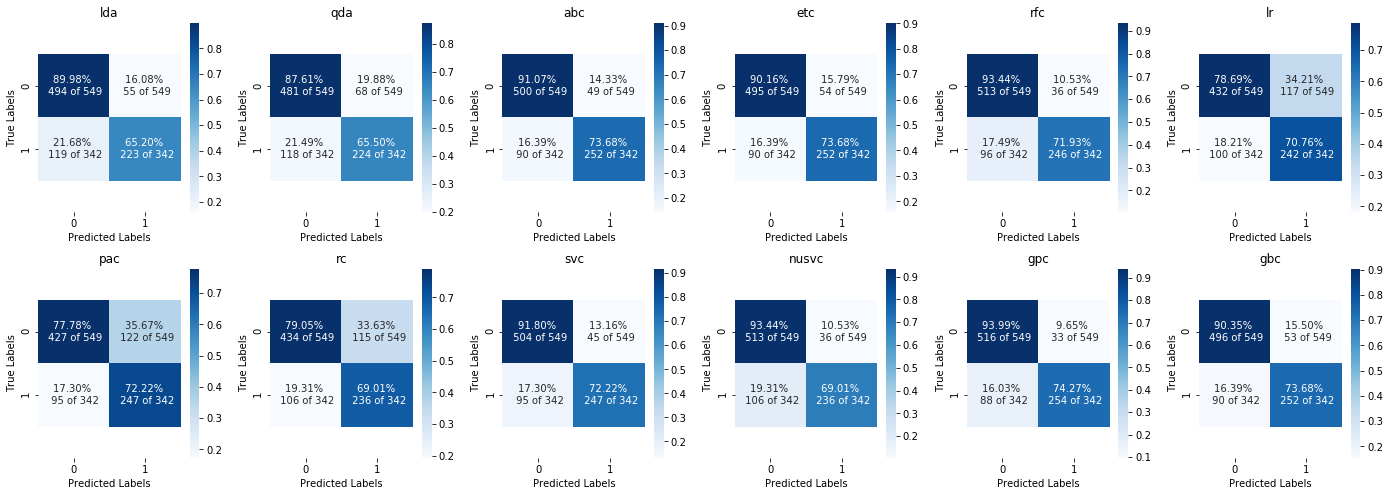

In [554]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

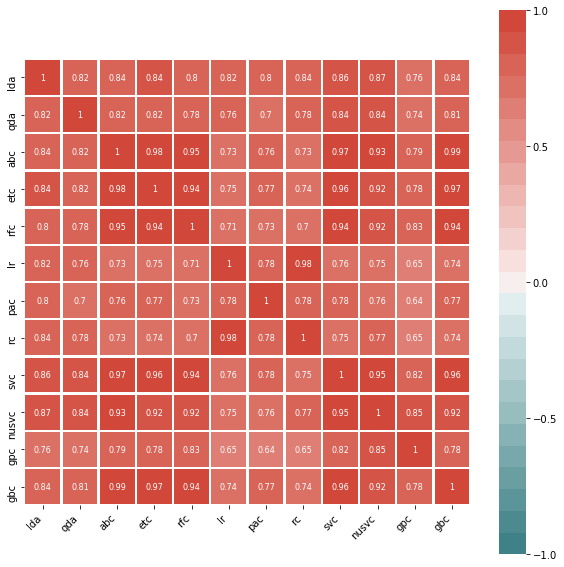

In [555]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [556]:
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,svc,abc,gbc,etc,nusvc,rfc,lda,qda,rc,lr,gpc,pac
cc,0.799005,0.791394,0.789467,0.789139,0.788641,0.769388,0.756093,0.726624,0.70457,0.701825,0.690924,0.689098


In [557]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'lr':lr,'pac':pac}

In [558]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

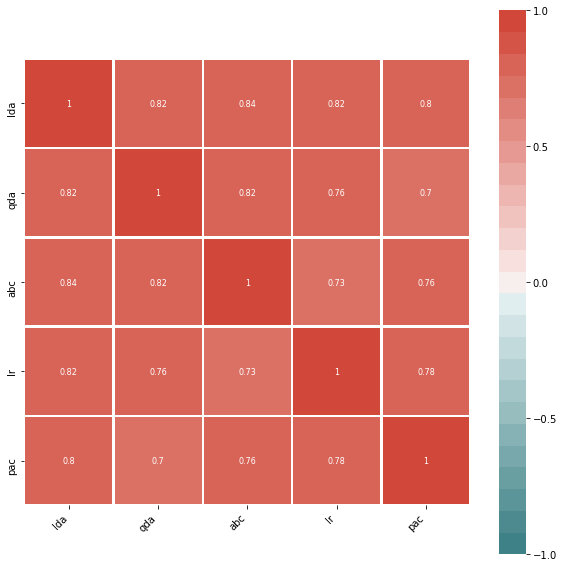

In [559]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [560]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [561]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('gbc', ens.GradientBoostingClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [562]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [563]:
scores

,lr,abc,svc,rfc,gbc,etc
Test_score,0.812312,0.811342,0.810794,0.808367,0.808367,0.807396
Train_score,0.826754,0.825779,0.826903,0.824860,0.824951,0.823212


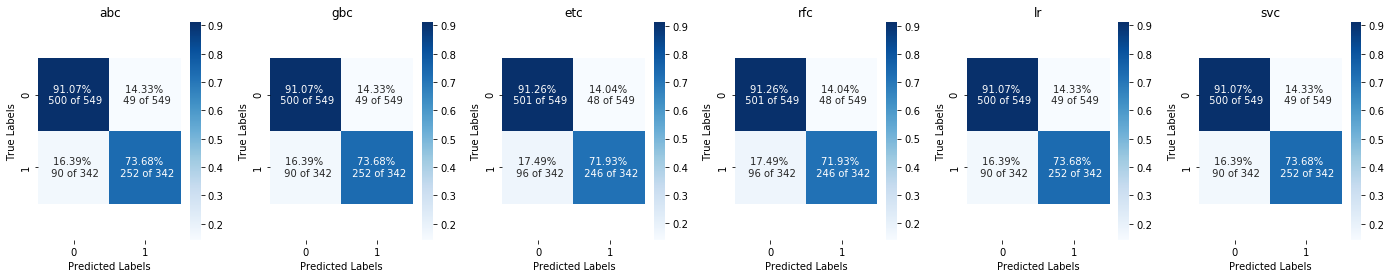

In [564]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [565]:
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, 
                                                                             criterion='entropy',
                                                                             n_estimators=25,
                                                                             max_depth=5,
                                                                             ccp_alpha=0.007428571428571),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

# param_ranges = {'final_estimator__n_estimators': np.arange(5, 100, 20),
#                 'final_estimator__max_depth': np.arange(5, 10)}
# model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

# param_ranges = {'final_estimator__ccp_alpha': np.linspace(0.001, 0.01, 15)}
# model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.827334,0.844183,0.843996
std_train,0.011500,0.013018,0.011481
mean_test,0.812798,0.828144,0.834610
std_test,0.021344,0.019086,0.020206


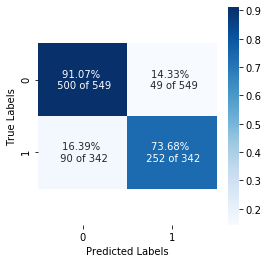

In [566]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')